In [226]:
from __future__ import print_function

import numpy as np
import scipy as sp
from numpy import cos, sin, log, exp, log10, absolute, pi, sqrt
from scipy.integrate import odeint
from scipy.integrate import quad
from numpy.polynomial import chebyshev as T
from numpy.polynomial import hermite_e as H
from spectral_tools import Decompose, ModalD, NodalD, Vandermonde
from edgedetect import ConfigurePlots, ChebEdgeIII, Enhance, LocateEdges, LocateEdgesDeriv, MinMod, PeaksInDeriv
from mollification import PiecewiseMollify
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [2]:
N = 32
c2s, s2c = Vandermonde(N)
modalD = ModalD(c2s)
nodalD = NodalD(c2s, s2c)

x = np.linspace(-1.0, 1.0, 500)
x_j = np.hstack((-1.0, T.Chebyshev.basis(N).deriv().roots(), 1.0))

sigma = 0.5/3.
#sigma2
gauss = lambda x: exp(-(x**2)/(2*(sigma**2)))
gauss2 = lambda x: exp(-(x**2)/(2*(sigma**2)))

gaussx = np.frompyfunc(gauss, 1, 1)(x)
g_norm = quad(gauss2, -np.inf, np.inf)[0]
gauss_norm = lambda x: (1./g_norm) * gauss(x)
gauss_normx = np.frompyfunc(gauss_norm, 1, 1)(x)

a_n = Decompose(gauss, c2s)
a_nnorm = Decompose(gauss_norm, c2s)

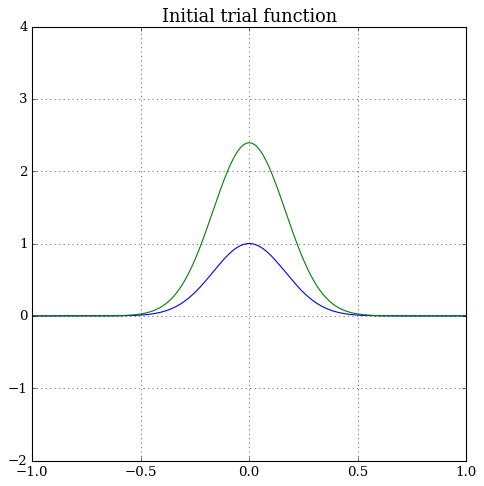

In [3]:
ConfigurePlots()
plt.plot(x, gaussx)
plt.plot(x, gauss_normx)
plt.title('Initial trial function', fontsize=16)

[  1.52299797e-08   1.81051844e-08   3.02153488e-08   6.94105814e-08
   2.12577113e-07   8.31418883e-07   3.94070510e-06   2.13211100e-05
   1.23409804e-04   7.14314582e-04   3.86478545e-03   1.83180585e-02
   7.16444943e-02   2.19418703e-01   5.04047783e-01   8.41194413e-01
   1.00000000e+00   8.41194413e-01   5.04047783e-01   2.19418703e-01
   7.16444943e-02   1.83180585e-02   3.86478545e-03   7.14314582e-04
   1.23409804e-04   2.13211100e-05   3.94070510e-06   8.31418884e-07
   2.12577113e-07   6.94105814e-08   3.02153491e-08   1.81051842e-08
   1.52299797e-08]


(-0.5, 1.5)

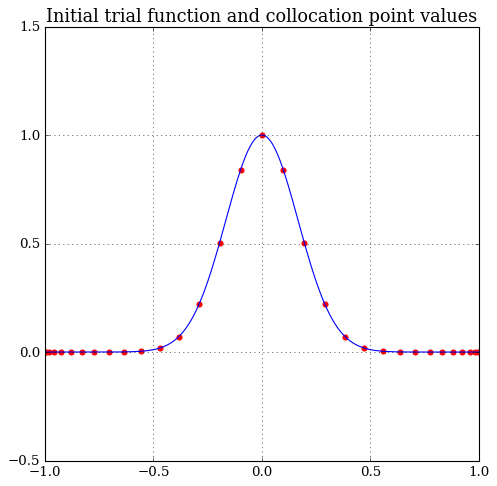

In [4]:
u_0 = np.array(np.dot(s2c, a_n), dtype='float64')
u_0[0] = u_0[-1]
print(u_0)

plt.plot(x, gaussx)
plt.title('Initial trial function and collocation point values', fontsize=16)
plt.scatter(x_j, u_0, c='r', edgecolor='face')
plt.xlim(-1.0, 1.0)
plt.ylim(-0.5, 1.5)

In [74]:
def GetQkEps(N, s):
    
    theta = ((2.*s)-1.)/(2.*s)
    m_N = N**theta
    Q_k = np.zeros(N+1)
    eps_N = N**(1.-(2.*s))
    
    for k, Q in enumerate(Q_k):
        
        if k >= m_N:
            Q_k[k] = 1.-(m_N/k)**4
    
    return Q_k, eps_N

def burgers(y, t0, modalD, nodalD, Q_k, eps_N):
    
    # using the structure of d_dt = -(A + B(C))
    
    N = modalD.shape[0] - 1
    w_N = pi/(2*N)
    
    y[0] = y[-1]
    
    F_u = 0.5 * np.power(y, 2)
    A = np.dot(nodalD, F_u)
    
    #C = Q_k * np.dot(c2s, np.dot(nodalD, y))
    #B = eps_N * np.dot(s2c, np.dot(modalD, C))
    #B[-1] = B[-1] + eps_N/w_N * np.dot(s2c, C)[-1]
    B = np.zeros(N+1)
    
    derivative = -(A + B)
    
    return derivative
    

fig, ax = plt.subplots(2,2, figsize=(14,14))
w_N = pi/(2*N)
F_u = 0.5 * np.power(u_0, 2)
ax[0,0].scatter(x_j, F_u, c='b', edgecolor='face')
A = np.dot(nodalD, F_u)
ax[0,0].scatter(x_j, A, c='r', edgecolor='face')
ax[0,0].set_xlim(-1.05, 1.05)

s = 2
Q_k, eps_N = GetQkEps(N, s)

a_nnum = np.arange(len(a_n))
a_nder = np.dot(c2s, np.dot(nodalD, u_0))
#a_nder = np.ma.masked_where(a_nnum % 2 == 0, a_nder)

C = Q_k * np.dot(c2s, np.dot(nodalD, u_0))
#C = np.ma.masked_where(a_nnum % 2 == 0, C)
ax[0,1].scatter(a_nnum, absolute(C), c='r', edgecolor='face')
ax[0,1].scatter(a_nnum, absolute(a_nder), c='b', edgecolor='face')

B_test = np.dot(s2c, np.dot(modalD, a_nder))
B = eps_N * np.dot(s2c, np.dot(modalD, C))
B[-1] = B[-1] + eps_N/w_N * np.dot(s2c, C)[-1]

ax[1,1].set_ylim(-60, 60)
ax2 = ax[1,1].twinx()
ax2.scatter(x_j, B, c='r', edgecolor='face')
ax2.set_ylim(-0.001, 0.001)
ax[1,1].scatter(x_j, B_test, c='b', edgecolor='face')

blah1 = np.dot(modalD, a_nder)
blah2 = np.dot(modalD, C)
ax[1,0].scatter(a_nnum, blah1, c='b', edgecolor='face')
ax[1,0].scatter(a_nnum, blah2, c='r', edgecolor='face')

#np.set_printoptions(threshold=np.inf)
#print(modalD)

In [75]:
t = np.linspace(0.0, 2.0, 200)

In [76]:
s = 2 
Q_k, eps_N = GetQkEps(N, s)
a_nnum = np.arange(len(a_n))
#plt.plot(a_nnum, Q_k)
evolved_burgers, dictio = odeint(burgers, u_0, t, args=(modalD, nodalD, Q_k, eps_N), full_output=1)

In [77]:
#print(dictio['hu'])

In [78]:
#evolved_burgers = np.ma.masked_where(absolute(evolved_burgers) > 1.5, evolved_burgers
print(evolved_burgers.shape)
#print(evolved_burgers)

(200, 33)


In [79]:
evolved_burgers_space = np.empty((len(t), len(x)))
#evolved_burgers[:,0] = evolved_burgers[:,-1]


for idx, t_n in enumerate(t):
    a_nn = np.dot(c2s, evolved_burgers[idx,:])
    evolved_burgers_space[idx,:] = T.chebval(x, a_nn)
    
#print(evolved_burgers_space)

/Users/asiamacbook/anaconda/lib/python2.7/site-packages/numpy/polynomial/chebyshev.py:1181: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/asiamacbook/anaconda/lib/python2.7/site-packages/numpy/polynomial/chebyshev.py:1181: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2


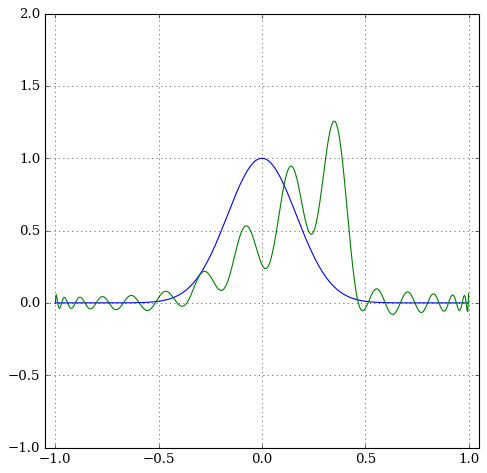

In [82]:
#plt.plot(x_j, evolved_burgers[54,:])
plt.xlim(-1.05, 1.05)
plt.plot(x, evolved_burgers_space[0,:])
plt.plot(x, evolved_burgers_space[45,:])
#plt.xlim(-1.05, 1.05)

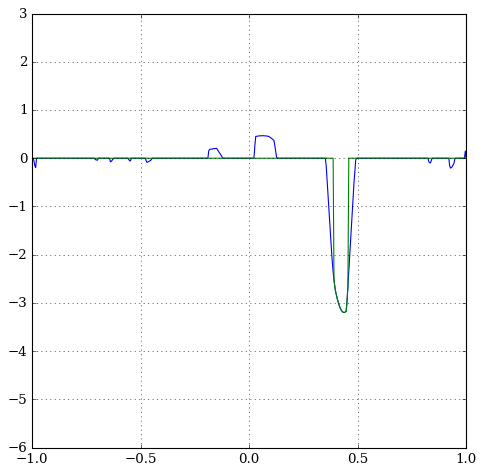

In [32]:
theta = 1./4.
a_n40 = np.dot(c2s, evolved_burgers[45,:])
c_j = LocateEdgesDeriv(a_n40, x, modalD)
c_jold = LocateEdges(a_n40, x, modalD)
mollified_40 = PiecewiseMollify(theta, c_j, a_n40, x)
mollified_40_old = PiecewiseMollify(theta, c_jold, a_n40, x)

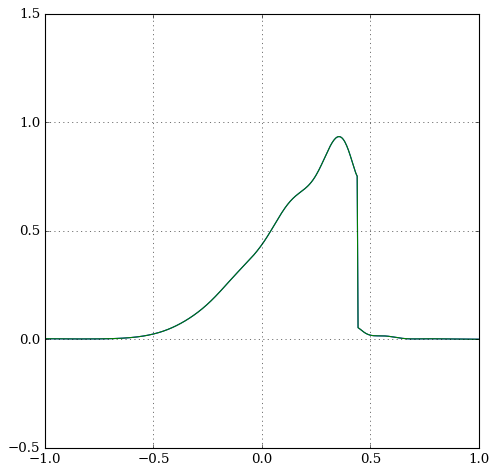

In [20]:
plt.plot(x, mollified_40[0])
plt.plot(x, mollified_40_old[0])

In [332]:
def GetQkEps_correct(N, s):
    
    theta = ((2.*s)-1.)/(2.*s)
    factor = 0.8 #prefactor to the epsilon
    
    m_N = N**theta
    Q_k = np.zeros(N+1)
    eps_N = factor*N**(1.-(2.*s))
    
    for k, Q in enumerate(Q_k):
        
        if k >= m_N:
            Q_k[k] = 1.-(m_N/k)**((2*s-1)/theta)
    
    return Q_k, eps_N

def burgers(y, t0, modalD, nodalD, Q_k, eps_N):
    
    # using the structure of d_dt = -(A + B(C))
    
    N = modalD.shape[0] - 1
    w_N = pi/(2*N)
    
    y[0] = y[-1]
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax1 = ax.twinx()
    
    F_u = 0.5 * np.power(y, 2)
    ax.plot(x_j, F_u)
    ax.set_ylim(-0.6, 0.6)
    A = np.dot(nodalD, F_u)
    ax1.plot(x_j, A, 'r')
    
    C = Q_k * np.dot(c2s, np.dot(nodalD, y))
    B = eps_N * np.dot(s2c, np.dot(modalD, C))
    B[-1] = B[-1] + eps_N/w_N * np.dot(s2c, C)[-1]
    
    derivative = -(A + B)
    
    return derivative

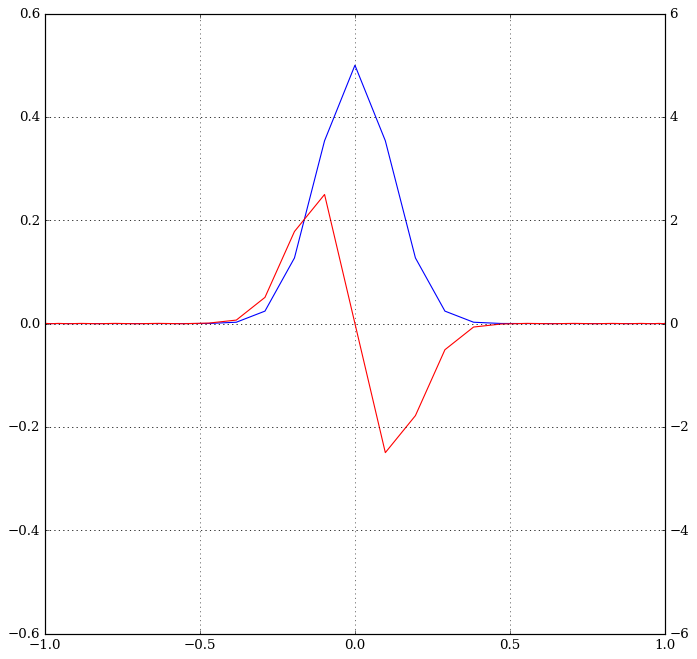

In [333]:
s = 1
t0 = 0
Q_k, eps_N = GetQkEps_correct(N, s)
test = burgers(u_0, t0, modalD, nodalD, Q_k, eps_N)

Now that's a crap result. Hopefully, if I write my own Runge-Kutta, test it and then try on Burgers, the problem shall vanish. Hopefully

In [339]:
def burgers2(y, t0, modalD, nodalD, Q_k, eps_N):
    
    # using the structure of d_dt = -(A + B(C))
    
    N = modalD.shape[0] - 1
    w_N = pi/(2*N)
    
    y[0] = y[-1]
    
    F_u = 0.5 * np.power(y, 2)
    A = - np.dot(nodalD, F_u)
    
    #C = Q_k * np.dot(c2s, np.dot(nodalD, y))
    #B = eps_N * np.dot(s2c, np.dot(modalD, C))
    #B[-1] = B[-1] + eps_N/w_N * np.dot(s2c, C)[-1]
    B = - np.zeros(N+1)
    
    derivative = A + B
    
    return derivative

def burgers3(y, t0, modalD, nodalD, Q_k, eps_N):
    
    # using the structure of d_dt = -(A + B(C))
    
    N = modalD.shape[0] - 1
    w_N = pi/(2*N)
    
    y[0] = y[-1]
    
    F_u = 0.5 * np.power(y, 2)
    A = - np.dot(nodalD, F_u)
    
    C = Q_k * np.dot(c2s, np.dot(nodalD, y))
    B = - eps_N * np.dot(s2c, np.dot(modalD, C))
    B[-1] = B[-1] - eps_N/w_N * np.dot(s2c, C)[-1]
    #B = np.zeros(N+1)
    #B[0] = B[-1]
    
    derivative = A + B
    derivative[0] = 0.0
    
    return derivative

In [340]:
def SimpleEuler(burgers, y0, t):
    
    N = y0.shape[0] - 1
    s = 1
    Q_k, eps_N = GetQkEps(N, s)
    
    dt = t[1] - t[0]
    
    output = np.empty((len(t), len(y0)))
    output[0,:] = y0
    
    for i in range(len(t)-1):

        derivative = burgers(output[i,:], i, modalD, nodalD, Q_k, eps_N) 
        output[i+1,:] = output[i,:] + dt * derivative
        output[i+1,0] = output[i+1,-1]
        
    return output

In [341]:
s = 1
Q_k, eps_N = GetQkEps_correct(N, s)
print(eps_N)
#plt.plot(np.arange(len(Q_k)), Q_k)

t = np.linspace(0, 1.0, 1000)
#euler_colloc2 = SimpleEuler(burgers2, u_0, t)
#euler_colloc3 = SimpleEuler(burgers3, u_0, t)

odeint_colloc3 = odeint(burgers3, u_0, t, args=(modalD, nodalD, Q_k, eps_N))
odeint_colloc2 = odeint(burgers2, u_0, t, args=(modalD, nodalD, Q_k, eps_N))

0.025


In [342]:
euler_colloc_space2 = np.empty((len(t), len(x)))
euler_colloc_space3 = np.empty((len(t), len(x)))
odeint_colloc_space2 = np.empty((len(t), len(x)))
odeint_colloc_space3 = np.empty((len(t), len(x)))

for idx, t_n in enumerate(t):
    a_nn2 = np.dot(c2s, euler_colloc2[idx,:])
    a_nn3 = np.dot(c2s, euler_colloc3[idx,:])
    a_nn2o = np.dot(c2s, odeint_colloc2[idx,:])
    a_nn3o = np.dot(c2s, odeint_colloc3[idx,:])
    
    euler_colloc_space2[idx,:] = T.chebval(x, a_nn2)
    euler_colloc_space3[idx,:] = T.chebval(x, a_nn3)
    odeint_colloc_space2[idx,:] = T.chebval(x, a_nn2o)
    odeint_colloc_space3[idx,:] = T.chebval(x, a_nn3o)

(-1.05, 1.05)

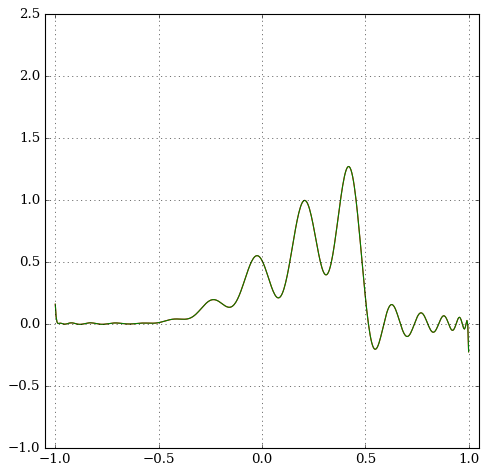

In [343]:
ConfigurePlots()
#plt.plot(x, euler_colloc_space2[0,:])
#plt.plot(x, euler_colloc_space2[150,:], 'g')
#plt.plot(x, euler_colloc_space3[150,:], 'r')
plt.plot(x, odeint_colloc_space3[560,:], 'r')
plt.plot(x, odeint_colloc_space2[560,:], 'g')

plt.xlim(-1.05, 1.05)
#plt.xlim(-1.05, -0.95)
#plt.xlim(0.95, 1.05)